# Project goal
`We are given dataset which contains signals of special device called magnetic flaw detector, which scannes the oil pipes with magnetic field to reveal possible deffects. The task is to classifiy signals by 2 cattegories: outter deffect ('OD') and inner deffect ('ID')`. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import random
from pathlib import Path
%matplotlib inline
plt.rcParams['font.size'] = 14

In [28]:
data = pd.read_csv('data.csv')
train =  pd.read_csv('target_train.csv')

## Binarize data

In [3]:
#label binarization (OD = 1, ID = 0)
defect_mapper = {0:'ID', 1:'OD'}
train_enc = train.copy()
enc = LabelEncoder()
train_enc.target = enc.fit_transform(train_enc.target)
train_enc

,id,target
0,111_1,1
1,103_1,1
2,34_2,0
3,78_1,1
4,71_2,1
...,...,...
95,136_1,1
96,183_1,0
97,26_2,1
98,6_2,1


## Normalization

`applies (X-X_mean)/std(X) normalization`

In [4]:
def normalilized_data(df):
    data_normed = data.copy()
    print('Normalizing data...')
    for i in (data.id.unique()):
        channels = data[data.id == i].iloc[:,3:]
        normed_channels = (channels - channels.mean().values)/channels.std().values
        data_normed.update(normed_channels)
    return data_normed

In [5]:
# create normalized dataset if it doesn't exist
path = Path('data_normed.csv')
if not path.is_file():
    data = normalilized_data(data)
    data.to_csv('data_normed.csv')
else:
    unnamed_cols = data.columns.values[data.columns.str.contains('Unnamed')]
    data = pd.read_csv('data_normed.csv').drop(unnamed_cols, axis = 1)

## Plotting signals of 2 different classes 

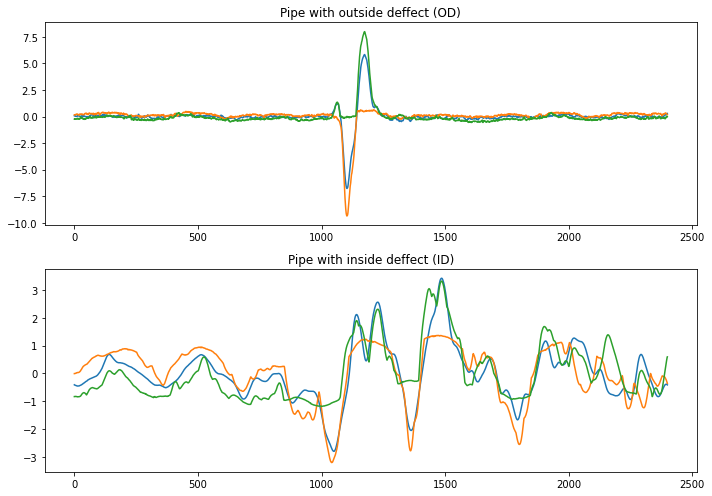

In [6]:
fig, axx = plt.subplots(2,1 , figsize = (10,7))
'''pipe num 111_1'''
plt.sca(axx[0])
pipe_1 = data[data.id == '111_1'].iloc[:,2:]
plt.plot(pipe_1.time, pipe_1.iloc[:,1:])
plt.title('Pipe with outside deffect (OD)')
''' pipe num 34_2'''
plt.sca(axx[1])
pipe_2 = data[data.id == '183_1'].iloc[:,2:]
plt.plot(pipe_2.time, pipe_2.iloc[:,1:] - pipe_2.iloc[:,1:].mean(axis = 0).values )
plt.title('Pipe with inside deffect (ID)')

plt.tight_layout()

## Building a CNN model

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam, SGD
from tqdm import trange

In [8]:
import os
def seed_everything(seed=10):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

### Creating dataset class for nn training

In [9]:
class PipeData(Dataset):
    def __init__(self, data, train, ids):
        self.ids = ids
        self.train = train
        self.channels_by_id = {}
        for i in ids:
            self.channels_by_id[i] = torch.FloatTensor(data[data.id == i]\
                                                  [['ch0','ch1' , 'ch2']].values)
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, i):
        self.id = self.ids[i]
        return (self.channels_by_id[self.id ], 
                self.train[self.train.id == self.id ].target.item())

### Spliting samples on train and validation sets

In [10]:
X = train_enc.id.values
y = train_enc.target.values
train_ids, val_ids, _, _ = train_test_split(X, y, test_size=0.3, 
                                                   random_state=100)
pd_train = PipeData(data, train_enc, train_ids)
pd_val = PipeData(data, train_enc, val_ids)
train_ids.shape, val_ids.shape

((70,), (30,))

### Making dataset iterable 

In [11]:
train_dloader = DataLoader(pd_train, batch_size = 1)
val_dloader =  DataLoader(pd_val, batch_size = 1)
for ch, lab in train_dloader:
    break
print(ch.shape , lab)

torch.Size([1, 2400, 3]) tensor([1])


### Creating model class

In [12]:
class PipeDataConv(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.num_ch = 3
        self.num_classes = 2
        torch.manual_seed(4)
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size = (1, self.num_ch) )
        self.maxpool = nn.MaxPool2d(kernel_size = (2400,1))
        self.fc = nn.Linear(out_dim,self.num_classes)
    def forward(self, x):
        out = self.conv(x)
        out = F.relu(out)
        out = self.maxpool(out)
        out = out.view(-1, out.size(0))
        return self.fc(out)
 

In [13]:
n_epochs = 60
seed_everything()
model = PipeDataConv(1, 5)
opt = SGD(model.parameters(), lr = 0.001)
log_train = []
log_val = []

### Training a model

In [29]:
for e in trange(n_epochs, position = 0, leave = True):
    for feat, label in train_dloader:
        logits = model(feat)
        train_loss = F.cross_entropy(logits, label)
        opt.zero_grad()
        train_loss.backward()
        opt.step()
    with torch.no_grad():
        log_train.append(train_loss.item())

    for feat, label in val_dloader:
        logits = model(feat)
        val_loss = F.cross_entropy(logits, label)
    with torch.no_grad():
        log_val.append(val_loss.item())

100%|██████████| 60/60 [00:03<00:00, 16.73it/s]


In [15]:
# log_train, log_val

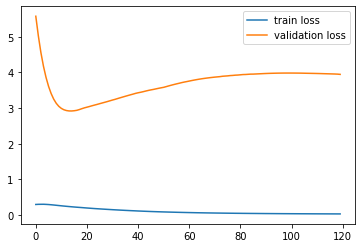

In [30]:
plt.figure()
plt.plot(np.array(log_train), label = 'train loss')
plt.plot(np.array(log_val), label = 'validation loss')
plt.legend()

### Model evaluation

In [17]:
def f1_score_eval(model, dloader):
    from sklearn.metrics import f1_score
    y_pred = []
    y_true = []
    y_pred_proba = []
    for feat, label in dloader:
            logits = model(feat)
            y_pred.append(torch.argmax(logits, 1).item())
            y_true.append(label.item())
            with torch.no_grad():
                y_pred_proba.append(F.softmax(model(feat))[0].numpy())
                
    return np.array(y_pred_proba)[:,1], f1_score(y_true, y_pred).round(2)

_, f1_train = f1_score_eval(model, train_dloader)
y_pred_proba_nn, f1_val = f1_score_eval(model, val_dloader)
print('Train set f1 score: %s \n Validation set f1 score: %s'% (f1_train, f1_val))

Train set f1 score: 0.93 
 Validation set f1 score: 0.95


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


### Classification of unlabeled pipes 

`Now we can classify unlabeled pipes with learned model`

In [18]:
#finding the labels of samples for which we should predict labels
ids = data.id.unique()
lab_ids = train.id.to_list()
unl_ids = list(set(ids).difference(set(lab_ids)))
print(len(unl_ids), unl_ids[:10])

145 ['137_2', '9_2', '123_1', '175_2', '182_1', '78_2', '178_1', '157_1', '176_1', '106_2']


In [19]:
def get_labels(unl_ids: list, pred_proba : torch.Tensor):
    predictions = {}
    for i, pipe_id in enumerate(unl_ids):
        predictions[pipe_id] = defect_mapper[torch.argmax(pred_proba[pipe_id]).item()]
    return predictions

unl_channels = {}
for i in unl_ids:
    unl_channels[i] = torch.FloatTensor(data[data.id == i]\
                                      [['ch0','ch1' , 'ch2']].values)
pred_proba = {} 
predictions = {}
for i, channel in unl_channels.items():
    with torch.no_grad():
        pred_proba[i] = F.softmax(model(channel[None, :, :]), dim = 1)

predictions = get_labels(unl_ids, pred_proba)

### save predictions in file

In [20]:
pred_data = pd.DataFrame(list(predictions.items()), columns = ['id','target'])
pred_data
pred_data.to_csv('predictions.csv')
pred_data

,id,target
0,137_2,OD
1,9_2,OD
2,123_1,ID
3,175_2,ID
4,182_1,ID
...,...,...
140,82_1,ID
141,60_2,ID
142,81_2,OD
143,97_1,OD


## Gradient Boosting with PCA

`Now lets try the Gradient boosting classifier with applied PCA to reduce channels dimensionality from 3 to 1`

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA 

In [22]:
gb = GradientBoostingClassifier(random_state = 0)

In [23]:
# prepare dataset 
def Dataset(data, train, ids):
    channels = []
    labels = []
    pca = PCA(n_components = 1)
    new_channel = pca.fit_transform(data[['ch0','ch1' , 'ch2']])
    data_new = data.drop(columns = ['ch0','ch1' , 'ch2'], axis = 1)
    data_new['ch'] = new_channel
    for i in ids:
        labels.append(train[train.id == i].target.item())
        channels.append(data_new[data_new.id == i].ch.values)
    return np.array(channels), np.array(labels)

X, y = Dataset(data, train_enc, train_enc.id.values)
X_tr, y_tr = Dataset(data, train_enc, train_ids)
X_val, y_val = Dataset(data, train_enc, val_ids)

In [24]:
f1_cv = cross_validate(gb, X, y, cv = 3,  scoring = 'f1')['test_score'].mean()
print('F1 score of GB model on cross validation %s' % round(f1_cv,2))

F1 score of GB model on cross validation 0.8


## ROC curve comparasion

`Now lets compare to classificators - CNN and Gradient Boosting by ROC curve and ROC AUC score`

F1 score on validation set for CNN: 0.95 
 F1 score on cross-validation for GB: 0.8 


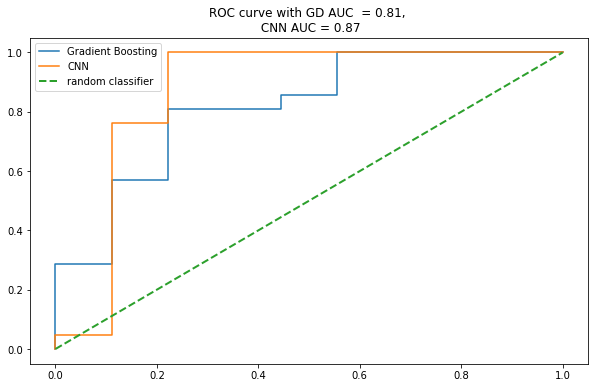

In [25]:
gb.fit(X_tr, y_tr)
y_pred_proba_gd = gb.predict_proba(X_val)[:,1]
fpr_gd, tpr_gd, _ = roc_curve(y_val, y_pred_proba_gd)
fpr_nn, tpr_nn,  _ = roc_curve(y_val, y_pred_proba_nn)
plt.figure(figsize = (10,6))
plt.plot(fpr_gd, tpr_gd, label = 'Gradient Boosting')
plt.plot(fpr_nn, tpr_nn, label = 'CNN')
plt.title('ROC curve with GD AUC  = %s, \n CNN AUC = %s' % (round(roc_auc_score(y_val, y_pred_proba_gd),2),
                                                            round(roc_auc_score(y_val, y_pred_proba_nn),2)
                                                           )
         )
x = np.linspace(0,1,10)
plt.plot(x, x, '--', lw = 2, label = 'random classifier')
plt.legend()
print('F1 score on validation set for CNN: %s \n F1 score on cross-validation for GB: %s ' % (f1_val,
                                                                                             round(f1_cv,2)))